In [1]:
DATA_CSV = "../results/average_node_values.csv"

GENERATE_DATA = False
# Parameters for generating data
MODEL_DIRECTORY = "../models/random_nk3"
UPDATE = "asynchronous"
N_RANDOM = 30 # number of random models
DEBUG = False
NSQUARE_STEPS = 20 # number of steps for nsquare

# Figure configuration
MAIN_FIGURE_ID = "8"
SUP_FIGURE_ID = "s6"
METRICS = ["rmsd"]
METHODS = None # plot all methods
FIGURE_DIR = "../results/figures"

In [2]:
import pandas as pd
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

import sdmarkov.plotting.config as pc
from sdmarkov.basins import get_average_node_values
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.matrix_operations import nsquare, compress_matrix, expand_matrix, get_rms_diff
from sdmarkov.transition_matrix import get_transition_matrix, get_uniform_matrix
from sdmarkov.attractors import get_predicted_attractors
from sdmarkov.analysis.utils import load_or_generate_data, add_classification_metrics, network_level_metrics_df
from sdmarkov.plotting.figures import plot_violin_figure, plot_distribution_figure, save_figure

## Data generation or loading

In [3]:
def get_data_average_node_values(
    bnet,
    bnet_name=None,
    update="asynchronous",
    num_runs=30,
    DEBUG=False,
):
    """
    Compute average node value comparison (RMSD) for SD, null,
    uniform, and random groupings of a Boolean network.

    Returns a long-format DataFrame with one row per method per run.
    """
    rows = []

    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    # Percolate constant nodes
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return pd.DataFrame(rows)

    percolated_bnet = primes2bnet(percolated_primes)
    n_states = 2 ** len(percolated_primes)
    stg = primes2stg(percolated_primes, update)

    # Full transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, NSQUARE_STEPS, DEBUG=DEBUG)

    # Grouped transition matrices
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)

    # Predicted attractors
    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)
    n_attractors = len(predicted_attractor_indices)

    if n_attractors < 2:
        return pd.DataFrame(rows)

    # Actual average node values
    avg_node_values = get_average_node_values(T_inf)

    # Reference
    Tref = get_uniform_matrix(n_states)
    ref_avg = get_average_node_values(Tref, DEBUG=DEBUG)

    # Helper to compute grouped average node values
    def grouped_avg(T_grouped, indices):
        T_grouped_inf = nsquare(T_grouped, NSQUARE_STEPS, DEBUG=DEBUG)
        T_grouped_inf_expanded = expand_matrix(T_grouped_inf, indices, DEBUG=DEBUG)
        return get_average_node_values(T_grouped_inf_expanded, DEBUG=DEBUG)

    sd_avg = grouped_avg(Tsd, sd_indices)
    null_avg = grouped_avg(Tnull, null_indices)

    # --- inner helper to add row ---
    def add_row(method, predictions, run=None):
        rmsd_val = get_rms_diff(avg_node_values, predictions, partial=True, DEBUG=DEBUG)
        rows.append({
            "bnet": bnet_name,
            "method": method,
            "run": run,
            "rmsd": rmsd_val,
            "n_states": n_states,
            "n_attractors": n_attractors
        })

    # Deterministic / reference methods
    add_row("sd_mc", sd_avg)
    add_row("null_mc", null_avg)
    add_row("ref", ref_avg)

    # Random runs
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        random_avg = grouped_avg(Trandom, random_indices)
        add_row("random_mc", random_avg, run=i)

    return pd.DataFrame(rows)

In [4]:
df = load_or_generate_data(
    data_csv=DATA_CSV,
    generate_data=GENERATE_DATA,
    data_function=get_data_average_node_values,
    model_directory=MODEL_DIRECTORY,
    update=UPDATE,
    n_random=N_RANDOM,
    debug=DEBUG,
)

Loaded cached results from ../results/average_node_values.csv.


In [5]:
print("Preview of results DataFrame:")
display(df.head())

print("\nDataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

Preview of results DataFrame:


,bnet,method,run,rmsd,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,0.117484,1024,2,asynchronous
1,n010_000.bnet,null_mc,NaN,0.150764,1024,2,asynchronous
2,n010_000.bnet,ref,NaN,0.350328,1024,2,asynchronous
3,n010_000.bnet,random_mc,0.0,0.150211,1024,2,asynchronous
4,n010_000.bnet,random_mc,1.0,0.151612,1024,2,asynchronous



DataFrame shape: (1518, 7)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


## Data analysis

In [6]:
# filter out networks with a single attractor
df_multi = df[df["n_attractors"] > 1].copy()

print("Dataframe filtered to networks with multiple attractors")
print("DataFrame shape:", df_multi.shape)
print("Methods present:", df_multi.method.unique())
print("Number of unique networks:", df_multi.bnet.nunique())

display(df_multi.head())

Dataframe filtered to networks with multiple attractors
DataFrame shape: (1518, 7)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


,bnet,method,run,rmsd,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,0.117484,1024,2,asynchronous
1,n010_000.bnet,null_mc,NaN,0.150764,1024,2,asynchronous
2,n010_000.bnet,ref,NaN,0.350328,1024,2,asynchronous
3,n010_000.bnet,random_mc,0.0,0.150211,1024,2,asynchronous
4,n010_000.bnet,random_mc,1.0,0.151612,1024,2,asynchronous


In [7]:
df_metrics = network_level_metrics_df(df=df_multi)

print("Preview of network-level metrics DataFrame:")
display(df_metrics.head())

print("\nDataFrame shape:", df_metrics.shape)
print("Methods present:", df_metrics.method.unique())
print("Number of unique networks:", df_metrics.bnet.nunique())

print("\nNetwork-level classification metrics:")
metrics = ["rmsd"]
summary = (
    df_metrics
    .groupby("method")[metrics]
    .agg(["mean", "min", "median", "max"])
)

display(summary)

Preview of network-level metrics DataFrame:


,bnet,method,rmsd,n_states,n_attractors,update_scheme
0,n010_000.bnet,null_mc,0.150764,1024.0,2.0,asynchronous
1,n010_000.bnet,random_mc,0.150743,1024.0,2.0,asynchronous
2,n010_000.bnet,ref,0.350328,1024.0,2.0,asynchronous
3,n010_000.bnet,sd_mc,0.117484,1024.0,2.0,asynchronous
4,n010_001.bnet,null_mc,0.119433,64.0,5.0,asynchronous



DataFrame shape: (184, 6)
Methods present: ['null_mc' 'random_mc' 'ref' 'sd_mc']
Number of unique networks: 46

Network-level classification metrics:


rmsd                         
               mean  min    median       max
method                                      
null_mc    0.104749  0.0  0.093702  0.407622
random_mc  0.104665  0.0  0.089169  0.407516
ref        0.301876  0.0  0.341540  0.475903
sd_mc      0.048434  0.0  0.031100  0.251570

## Plotting

In [8]:
pc.apply_style()

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


PosixPath('../results/figures/Figure_8_Average_node_values.png')

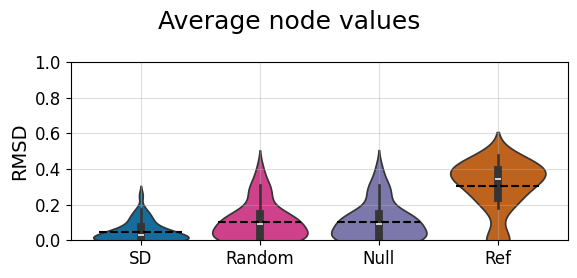

In [9]:
fig1 = plot_violin_figure(df_metrics, metrics=METRICS, figure_id=MAIN_FIGURE_ID)

save_figure(fig1, figure_id=MAIN_FIGURE_ID, outdir=FIGURE_DIR)

PosixPath('../results/figures/Figure_s6_Average_node_values.png')

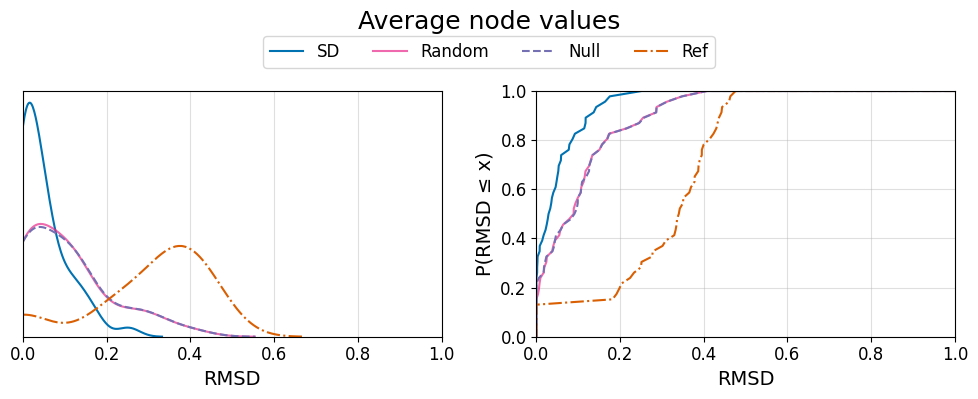

In [10]:
fig2 = plot_distribution_figure(df_metrics, metrics=METRICS, figure_id=SUP_FIGURE_ID)

save_figure(fig2, figure_id=SUP_FIGURE_ID, outdir=FIGURE_DIR)